# Tokenizer
[参考博客](https://zhuanlan.zhihu.com/p/631463712)
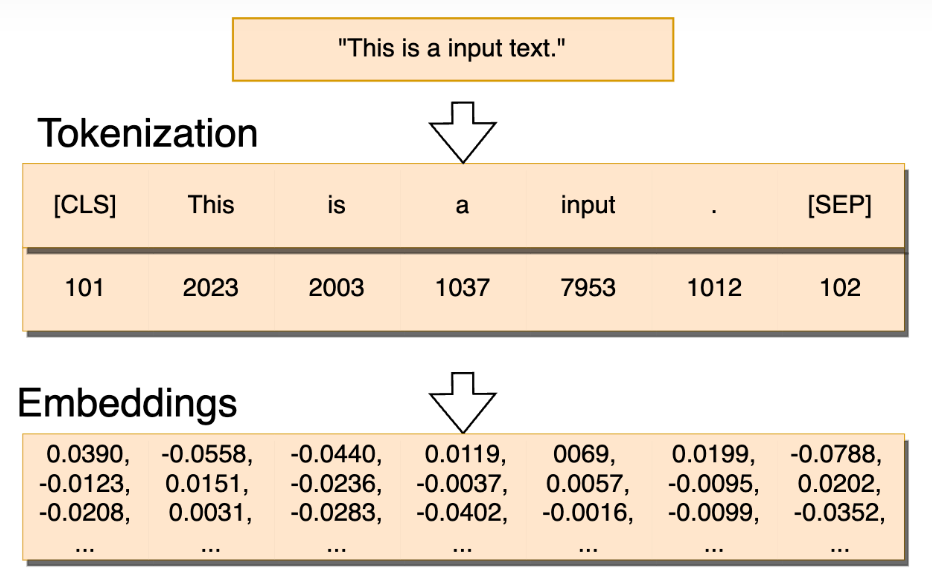

## (1) Tokenizer在做什么
在使用模型前，都需要将sequence过一遍tokenizer，进去的是**word序列（句子），出来的是number序列，本质上是独热编码**。
#### 具体实现
1. **分词**：将字符串分成sub-word token string，再将token string映射到id，并保留来回映射的mapping。从string映射到id为**tokenizer encode**过程，从id映射回token为**tokenizer decode**过程。

2. **扩展词汇表**：部分tokenizer会用一种统一的方法将**训练语料出现的**且**词汇表中本来没有的**token加入词汇表。对于不支持的tokenizer，用户也可以手动添加。

3. **识别并处理特殊token**：特殊token包括`[MASK]`, `<|im_start|>`, `<sos>`, `<s>`等等。tokenizer会将它们加入词汇表中，并且保证它们在模型中不被切成sub-word，而是完整保留。

## (2) 不同的Tokenizer
[参考博客](https://zhuanlan.zhihu.com/p/631463712)

#### 分词粒度
不同语言有不同的编码方式。如英语用gbk编码，但中文需要用utf-8（一个中文需要用两个字节来表示）。tokenizer对应不同的粒度也有不同的分词方式。常见的一般有:
word base: 按照词进行分词

character base：按照单字符进行分词,就是以char为最小粒
]
subword tokenization：按照词的subword进行

word base方法简单易理解，每个word都分配一个ID，则所需的Vocabulary则根据语料大小而不同，而且这种分词方式，会将**两个本身意思一致的词分成两个毫不同的ID**，在英文中尤为明显，如cat， cats。

在character base中此种现象有减缓，而且Vocabulary相对小的多，但分词后的每个char字符是毫无意义的，而且输入的长度变长不少，只有组装后才有意义，这种分词在模型的初始character embedding是无意义的。英文中明显**，但中文却是较为合理，中文中用方式**较多。

最后为了平衡以上两种方法， 又提出了subword tokenization，典型的如Byte Pair Encoding (BPE)，Wordpiece，Sentenc等。.]， .]

### Byte-Pair Encoding (BPE)
在该项目中使用的也是该分词方法

而BBPE(Byte-level BPE),则是在字节层面进行BPE,这样对于未知语言和生僻字,就都可以编码成相应的UTF-8编码.但这样也会造成一个中文生僻字等于多个token的情况.

#### 1. 子词词表构造算法
[详细过程演示以及代码实现](https://zhuanlan.zhihu.com/p/378323693)
1. 统计输入中所有出现的单词并在每个单词后加一个单词结束符</w> -> `['hello</w>': 6, 'world</w>': 8, 'peace</w>': 2]`
2. 将所有单词拆成单字 ->` {'h': 6, 'e': 10, 'l': 20, 'o': 14, 'w': 8, 'r': 8, 'd': 8, 'p': 2, 'a': 2, 'c': 2, '</w>': 3`}
3. 合并最频繁出现的单字(l, o) -`> {'h': 6, 'e': 10, 'lo': 14, 'l': 6, 'w': 8, 'r': 8, 'd': 8, 'p': 2, 'a': 2, 'c': 2, '</w>': `3}
4. 合并最频繁出现的单字(lo, e) `-> {'h': 6, 'lo': 4, 'loe': 10, 'l': 6, 'w': 8, 'r': 8, 'd': 8, 'p': 2, 'a': 2, 'c': 2, '</w>':` 3}
5. 反复迭代直到满足

显然，这是一种贪婪的算法。在上面的例子中，'loe'这样的子词貌似不会经常出现，但是当语料库很大的时候，诸如est，ist，sion，tion这样的特征会很清晰地显示出

#### 2. 句子分割（编码）
在之前的算法中，我们已经得到了subword的词表，对该词表**按照字符个数由多到少排序**。编码时，对于每个单词，遍历排好序的子词词表寻找**是否有token是当前单词的子字符串**，如果有，则该token是表示单词的tokens之一。

我们从最长的token迭代到最短的token，尝试将每个单词中的子字符串替换为token。 最终，我们将迭代所有tokens，并将所有子字符串替换为tokens。 如果仍然有子字符串没被替换但所有token都已迭代完毕，则将剩余的子词替换为**特殊token**，如`<unk

在本项目的tokenizer中有些许不同，编码部分会尝试将相邻的token合并，通过记录最高得分的目的是为了找到最佳的合并策略，即选择得分最高的合并结果。这样可以在编码过程中尽可能地合并相邻的标记，以减少标记的数量，提高编码的效率和准确性。>` 。

#### 3. 解码
将所有的tokens拼在一起即可停止条件

## (3) 本项目的代码实现
运用了现成的词表

在`__init__`方法中，通过加载模型路径 `model_path` 中的词表文件，将词表的内容读取到 `self.vocab` 中。词表文件是一个 `JSON` 格式的文件，其中包含了词表中的标记（tokens）和每个标记的得分（scores）。

In [ ]:
class Tokenizer:
    def __init__(self, model_path: str):
        # 加载词表
        with open(model_path, "r", encoding="utf-8") as f:
            model = json.load(f)
        self.vocab = model["tokens"]
        self.scores = model["scores"]
        self.pad_id = 0 #填充符
        self.bos_id = 1 #起始符
        self.eos_id = 2 #结束符
        self.n_words = len(self.vocab)
        special_tokens = ["[MASK]", "[gMASK]", "[sMASK]", "sop", "eop"]
        self.special_tokens = {} # 储存特殊符号的索引
        self.index_special_tokens = {} # 储存索引对应的特殊符号
        # 建立映射关系，方便在编码和解码的过程中使用特殊符号
        for token in special_tokens:
            self.special_tokens[token] = self.n_words
            self.index_special_tokens[self.n_words] = token
            self.n_words += 1

    def str_lookup(self, token: str) -> int: # 查找此词表中是否有相应的token
        try:
            index = self.vocab.index(token)
            return index
        except ValueError as err:
            return -1

    def encode(
            self,
            text: str,
            add_bos: bool = True,
            add_eos: bool = False,
            add_prefix: bool = True,
            add_new_bos: bool = False,
    ) -> list[int]:
        tokens = []
        for pos, char in enumerate(text):
            id = self.str_lookup(char)
            if id >= 0: #如果此表中存在这个token
                tokens.append(id)
            else: #将字符转换为字节编码，并将编码后的整数值添加到tokens中
                tokens = tokens + [(i + 3) for i in char.encode()]
        while True:
            best_score = -1e10
            best_id = -1
            best_idx = -1

            for i in range(len(tokens) - 1):
                # 尝试将每对相邻的两个token合并为string，记录string在词表中的得分
                string = self.vocab[tokens[i]] + self.vocab[tokens[i + 1]]
                id = self.str_lookup(string)
                # 更新最高分
                if id != -1 and self.scores[id] > best_score:
                    best_score = self.scores[id]
                    best_id = id
                    best_idx = i

            if best_idx == -1:
                break

            # Merge the consecutive pair (best_idx, best_idx+1) into new token best_id
            tokens[best_idx] = best_id
            # Delete token at position best_idx+1, shift the entire sequence back 1
            tokens = tokens[0: best_idx + 1] + tokens[best_idx + 2:]
        if add_bos:
            tokens.insert(0, self.bos_id)
        if add_eos:
            tokens.append(self.eos_id)
        if add_prefix:
            tokens.insert(0, self.special_tokens['sop'])
            tokens.insert(0, self.special_tokens['[gMASK]'])
        if add_new_bos:
            tokens.append(self.bos_id)
        return tokens

    def decode(self, ids: list[int]) -> str:
        res = []
        for i in ids:
            token = self.vocab[i]
            res.append(token)
        text = "".join(res)
        text = text.strip("<s>").strip("</s>")
        return text

作者给的github代码中似乎没有相应的词表文件，[可以在这里找到](https://github.com/likejazz/llama3.np/blob/main/tokenizer.model.np)